RMSE (OwnDoc_SoldTulips): 93.72
sMAPE (OwnDoc_SoldTulips): 63.78
MAPE (OwnDoc_SoldTulips): 15267.25

RMSE (CashierData_CutFlowers): 204.02
sMAPE (CashierData_CutFlowers): 37.59
MAPE (CashierData_CutFlowers): 49.51


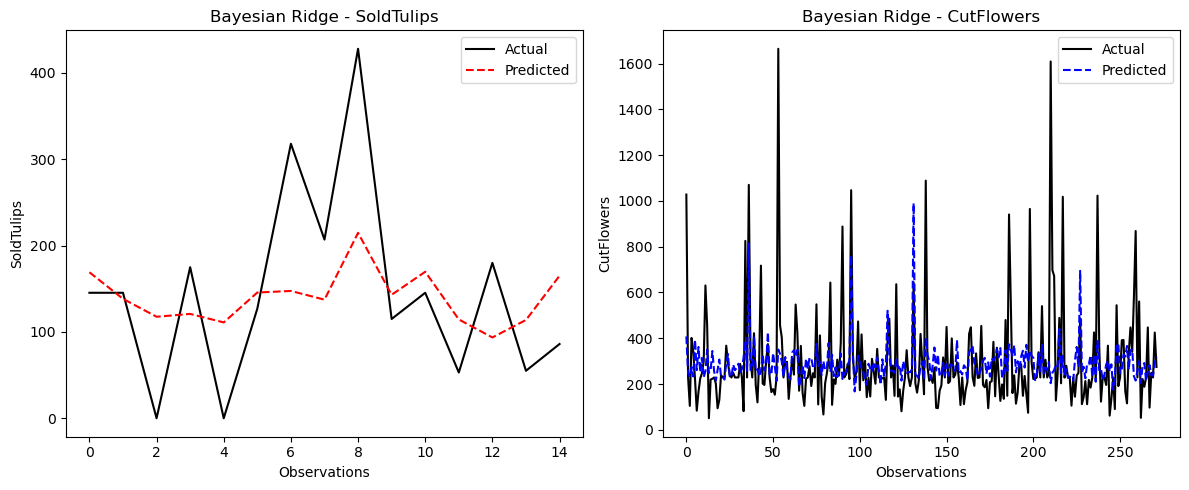

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load datasets
owndoc = pd.read_csv('OwnDoc_preprocessed.csv')
cashierdata = pd.read_csv('CashierData_preprocessed.csv')

# Convert date/time columns to numerical values
for col in owndoc.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        owndoc[col] = pd.to_datetime(owndoc[col]).map(pd.Timestamp.toordinal)

for col in cashierdata.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        cashierdata[col] = pd.to_datetime(cashierdata[col]).map(pd.Timestamp.toordinal)

# Convert categorical columns to numerical using Label Encoding
label_encoders = {}
for col in owndoc.columns:
    if owndoc[col].dtype == 'object':  
        le = LabelEncoder()
        owndoc[col] = le.fit_transform(owndoc[col])
        label_encoders[col] = le  

for col in cashierdata.columns:
    if cashierdata[col].dtype == 'object':  
        le = LabelEncoder()
        cashierdata[col] = le.fit_transform(cashierdata[col])
        label_encoders[col] = le  

# Define target variables
target_owndoc = 'SoldTulips'
target_cashier = 'CutFlowers'

# Separate features and target
X_owndoc = owndoc.drop(columns=[target_owndoc])
y_owndoc = owndoc[target_owndoc]

X_cashier = cashierdata.drop(columns=[target_cashier])
y_cashier = cashierdata[target_cashier]

# Replace zeros in target variable to avoid prediction issues
y_cashier = y_cashier.replace(0, np.median(y_cashier[y_cashier > 0]))

# Train-test split
X_train_owndoc, X_test_owndoc, y_train_owndoc, y_test_owndoc = train_test_split(
    X_owndoc, y_owndoc, test_size=0.15, random_state=20
)
X_train_cashier, X_test_cashier, y_train_cashier, y_test_cashier = train_test_split(
    X_cashier, y_cashier, test_size=0.2, random_state=10
)

# Standardize features
scaler = StandardScaler()
X_train_owndoc = scaler.fit_transform(X_train_owndoc)
X_test_owndoc = scaler.transform(X_test_owndoc)
X_train_cashier = scaler.fit_transform(X_train_cashier)
X_test_cashier = scaler.transform(X_test_cashier)

# Initialize Bayesian Ridge model
bayes_model_owndoc = BayesianRidge()
bayes_model_cashier = BayesianRidge()

# Fit model
bayes_model_owndoc.fit(X_train_owndoc, y_train_owndoc)
bayes_model_cashier.fit(X_train_cashier, y_train_cashier)

# Predictions
y_pred_owndoc = bayes_model_owndoc.predict(X_test_owndoc)
y_pred_cashier = bayes_model_cashier.predict(X_test_cashier)

# Evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, 0.1, y_true)
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

# Compute metrics
rmse_owndoc = rmse(y_test_owndoc, y_pred_owndoc)
rmse_cashier = rmse(y_test_cashier, y_pred_cashier)

smape_owndoc = smape(y_test_owndoc, y_pred_owndoc)
smape_cashier = smape(y_test_cashier, y_pred_cashier)

mape_owndoc = mape(y_test_owndoc, y_pred_owndoc)
mape_cashier = mape(y_test_cashier, y_pred_cashier)

# Print metrics
print(f"RMSE (OwnDoc_SoldTulips): {round(rmse_owndoc, 2)}")
print(f"sMAPE (OwnDoc_SoldTulips): {round(smape_owndoc, 2)}")
print(f"MAPE (OwnDoc_SoldTulips): {round(mape_owndoc, 2)}")

print(f"\nRMSE (CashierData_CutFlowers): {round(rmse_cashier, 2)}")
print(f"sMAPE (CashierData_CutFlowers): {round(smape_cashier, 2)}")
print(f"MAPE (CashierData_CutFlowers): {round(mape_cashier, 2)}")

# Plot predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test_owndoc.values, label="Actual", color="black")
plt.plot(y_pred_owndoc, label="Predicted", linestyle="dashed", color="red")
plt.xlabel("Observations")
plt.ylabel("SoldTulips")
plt.title("Bayesian Ridge - SoldTulips")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_cashier.values, label="Actual", color="black")
plt.plot(y_pred_cashier, label="Predicted", linestyle="dashed", color="blue")
plt.xlabel("Observations")
plt.ylabel("CutFlowers")
plt.title("Bayesian Ridge - CutFlowers")
plt.legend()

plt.tight_layout()
plt.show()
